In [1]:
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import hopsworks

In [3]:
import os
from dotenv import load_dotenv, find_dotenv

zzz = load_dotenv(find_dotenv())
zzz

True

In [4]:
from src.utility import (taxi_connect_to_project, taxi_create_feature_view, 
taxi_fetch_data_from_feature_store, taxi_insert_data_into_feature_store)

In [5]:
project = taxi_connect_to_project()

Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/571540


### 1. DOWNLOAD & PROCESS PREV MONTH'S DATA:

In [6]:
from src.feature_pipeline import taxi_download_timeseries_month

In [7]:
year, month = 2023, 1
location = 90

df_demand_jan_2023 = taxi_download_timeseries_month(year, month, location)
df_demand_jan_2023

,date_time,demand
0,2023-01-01 00:00:00,103
1,2023-01-01 01:00:00,66
2,2023-01-01 02:00:00,86
3,2023-01-01 03:00:00,87
4,2023-01-01 04:00:00,78
...,...,...
739,2023-01-31 19:00:00,103
740,2023-01-31 20:00:00,99
741,2023-01-31 21:00:00,90
742,2023-01-31 22:00:00,112


### 2. FETCH PREDICTIONS MADE FOR PREV MONTH FROM FEATURE STORE:

##### CREATE FEATURE VIEW:

In [8]:
feat_view_name = 'nyc_taxi_demand_prediction_jan_2023'
feat_view_ver = 1
parent_feat_group_name = 'nyc_taxi_demand_prediction_jan_2023'
parent_feat_group_ver = 1

taxi_create_feature_view(project, feat_view_name, feat_view_ver, 
                         parent_feat_group_name, parent_feat_group_ver)

Connected. Call `.close()` to terminate connection gracefully.


'Feature view nyc_taxi_demand_prediction_jan_2023 already exists.'

##### FETCH DATA:

In [9]:
feat_view_name, feat_view_ver = "nyc_taxi_demand_prediction_jan_2023", 1

df_pred_jan_2023 = taxi_fetch_data_from_feature_store(project, feat_view_name, feat_view_ver)
df_pred_jan_2023

Connected. Call `.close()` to terminate connection gracefully.


Finished: Reading data from Hopsworks, using Hive (7.31s) 


,date_time,demand
26,2023-01-01 00:00:00,57.896683
179,2023-01-01 01:00:00,54.317245
365,2023-01-01 02:00:00,50.874168
642,2023-01-01 03:00:00,42.993507
127,2023-01-01 04:00:00,23.888659
...,...,...
86,2023-01-31 19:00:00,96.848862
174,2023-01-31 20:00:00,91.671013
408,2023-01-31 21:00:00,79.002838
622,2023-01-31 22:00:00,73.072212


### 3. MONITOR MODEL (CHECK MODEL'S PERFORMANCE FOR PREVIOUS MONTH):

In [12]:
from src.training_pipeline import taxi_display_forecaster_performance

COMPARE PREDICTION & ACTUAL DATA:

In [10]:
y = df_demand_jan_2023.demand.values
y_pred = df_pred_jan_2023.demand.values
y.shape, y_pred.shape

((744,), (744,))


#############################
REGRESSION METRICS: 
mae = 14.264, r2 = 0.785
#############################


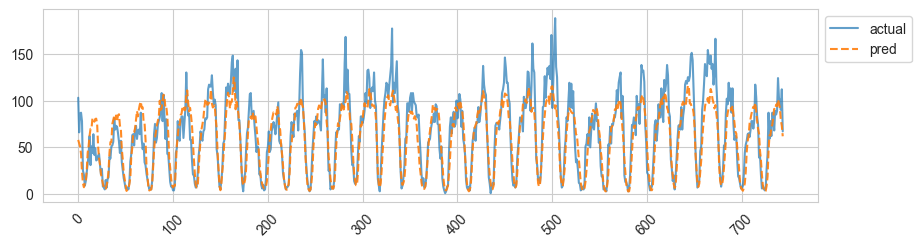

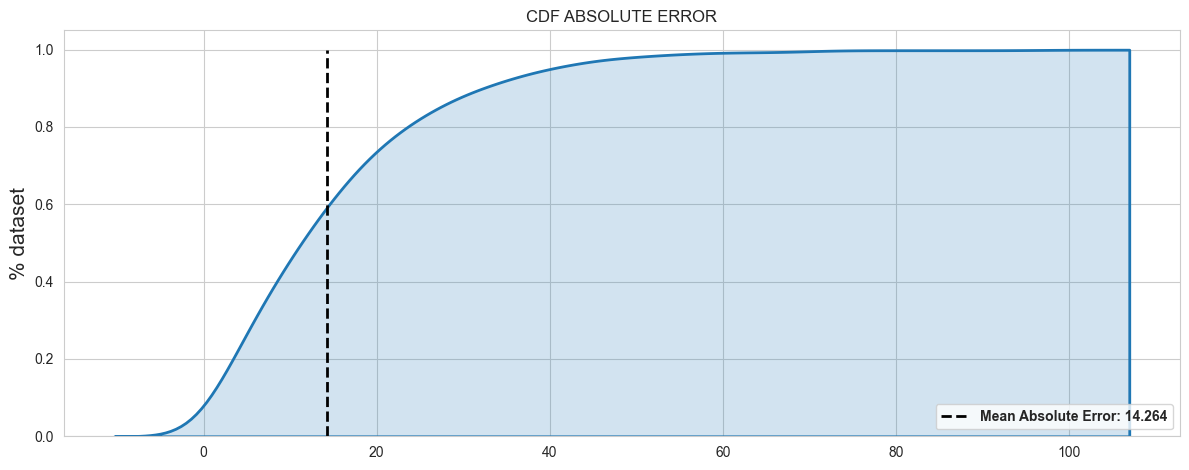

{'mae': 14.264, 'r2': 0.785}

In [13]:
taxi_display_forecaster_performance(y, y_pred)

### 4. TRAIN MODEL ON PREV DATA TILL NOW:

##### DOWNLOAD BACKFILL DATA FROM FEATURE STORE:

In [18]:
feat_view_name, feat_view_ver = "backfilled_2020_22", 1

df_demand_2020_22 = taxi_fetch_data_from_feature_store(project, feat_view_name, feat_view_ver)
df_demand_2020_22

Connected. Call `.close()` to terminate connection gracefully.


Finished: Reading data from Hopsworks, using Hive (13.68s) 


,date_time,demand
1235,2020-01-01 00:00:00,266
14783,2020-01-01 01:00:00,231
17253,2020-01-01 02:00:00,244
22409,2020-01-01 03:00:00,259
7476,2020-01-01 04:00:00,144
...,...,...
18612,2022-12-31 19:00:00,99
26016,2022-12-31 20:00:00,101
9736,2022-12-31 21:00:00,103
14795,2022-12-31 22:00:00,63


##### CONCAT PREV MONTH'S DOWNLOADED DATA WITH BACKFILL DATA:

In [19]:
combine = [df_demand_2020_22, df_demand_jan_2023]
df_backfill_2020_jan2023 = pd.concat(combine).sort_values(by = 'date_time')

df_backfill_2020_jan2023

,date_time,demand
1235,2020-01-01 00:00:00,266
14783,2020-01-01 01:00:00,231
17253,2020-01-01 02:00:00,244
22409,2020-01-01 03:00:00,259
7476,2020-01-01 04:00:00,144
...,...,...
739,2023-01-31 19:00:00,103
740,2023-01-31 20:00:00,99
741,2023-01-31 21:00:00,90
742,2023-01-31 22:00:00,112


#### TRAINING:

In [20]:
from src.training_pipeline import (taxi_create_ml_dataset, taxi_train_ml_model)

In [21]:
df_demand = df_backfill_2020_jan2023

df_ml = taxi_create_ml_dataset(df_demand)
df_ml.shape

(26376, 673)

In [22]:
import xgboost as xgb

untrained_model = xgb.XGBRegressor(random_state = 8)
trained_model = taxi_train_ml_model(untrained_model, df_ml)
trained_model

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=8, ...)

##### SAVE TRAINED MODEL TO MODEL REGISTRY:

In [23]:
from src.training_pipeline import taxi_save_model_to_registry

In [24]:
description = """
xgboost default model trained on backfilled data 2020-Jan 23

xgboost regressor trained of ml data got by using lagged features.

It predicts next value given previous 24*28 hrs (ie: 28 days) values.

It is used for time series forecasting by recursively feeding it its own previous predictions
that become part of the input data for the next step.
Used with the following function: "taxi_make_forecast(df_tr, model, forecasting_horizon)"
"""

model_name = "model_2020_jan23"
performance_dict = {}

In [25]:
taxi_save_model_to_registry(project, trained_model, model_name, description, df_ml,
                            performance_dict)

Connected. Call `.close()` to terminate connection gracefully.


  0%|          | 0/6 [00:00<?, ?it/s]

Uploading: 0.000%|          | 0/451550 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/3157 elapsed<00:00 remaining<?

Uploading: 0.000%|          | 0/226 elapsed<00:00 remaining<?

Model created, explore it at https://c.app.hopsworks.ai:443/p/571540/models/model_2020_jan23/1


### 5. MAKE FORECAST FOR NEXT MONTH'S DEMAND:

In [26]:
from src.inference_pipeline import load_model_from_registry, taxi_make_forecast

In [35]:
model_name, version = 'model_2020_jan23', 1

trained_model = load_model_from_registry(project, model_name, version)

Connected. Call `.close()` to terminate connection gracefully.


In [74]:
start_ = f'{year}-{month+1}-1'
end_ = f'{year}-{month+2}-1' 

if month == 11:
    start_ = f'{year}-{month+1}-1'
    end_ = f'{year+1}-{1}-1' 
if month == 12:
    start_ = f'{year+1}-1-1'
    end_ = f'{year+1}-2-1' 

start_, end_

('2023-2-1', '2023-3-1')

In [75]:
date_time_ = pd.date_range(start = start_, end = end_, freq= 'h', inclusive = 'left')
date_time_

DatetimeIndex(['2023-02-01 00:00:00', '2023-02-01 01:00:00',
               '2023-02-01 02:00:00', '2023-02-01 03:00:00',
               '2023-02-01 04:00:00', '2023-02-01 05:00:00',
               '2023-02-01 06:00:00', '2023-02-01 07:00:00',
               '2023-02-01 08:00:00', '2023-02-01 09:00:00',
               ...
               '2023-02-28 14:00:00', '2023-02-28 15:00:00',
               '2023-02-28 16:00:00', '2023-02-28 17:00:00',
               '2023-02-28 18:00:00', '2023-02-28 19:00:00',
               '2023-02-28 20:00:00', '2023-02-28 21:00:00',
               '2023-02-28 22:00:00', '2023-02-28 23:00:00'],
              dtype='datetime64[ns]', length=672, freq='H')

In [99]:
past_28_days_demand = df_backfill_2020_jan2023.demand.values[-24*28:]
y_pred =  taxi_make_forecast(past_28_days_demand, trained_model, forecast_horizon = len(date_time_))

y_pred.shape

(672,)

In [100]:
y_pred = pd.DataFrame().assign(date_time = date_time_, demand = y_pred)
y_pred

,date_time,demand
0,2023-02-01 00:00:00,36.738491
1,2023-02-01 01:00:00,16.624039
2,2023-02-01 02:00:00,10.545512
3,2023-02-01 03:00:00,6.754012
4,2023-02-01 04:00:00,4.041311
...,...,...
667,2023-02-28 19:00:00,132.875549
668,2023-02-28 20:00:00,128.069382
669,2023-02-28 21:00:00,122.281845
670,2023-02-28 22:00:00,112.343445


### 6. SAVE FORECAST TO FEATURE STORE:

In [39]:
data = y_pred
year_, month_ = pd.to_datetime(start_).year, pd.to_datetime(start_).month
feat_group_name = f'nyc_taxi_demand_prediction_{year_}_{month}'
feat_group_ver = 1

taxi_insert_data_into_feature_store(project, data, feat_group_name, feat_group_ver)

Connected. Call `.close()` to terminate connection gracefully.
Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/571540/fs/567363/fg/728413


Uploading Dataframe: 0.00% |          | Rows 0/672 | Elapsed Time: 00:00 | Remaining Time: ?

Launching job: nyc_taxi_demand_prediction_feb_2023_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/571540/jobs/named/nyc_taxi_demand_prediction_feb_2023_1_offline_fg_materialization/executions
data successfully inserted in feature store
